## About the contest

The goal of this competition is to provide a simple extension to the classic MNIST competition we're all familiar with. Instead of using classic MNIST with La LeCunn, it uses a recently-released dataset of Kannada digits.Kannada is a language spoken predominantly by people of Karnataka in southwestern India. The language has roughly 45 million native speakers and is written using the [Kannada script](https://en.wikipedia.org/wiki/Kannada). This work was made available by efforts of amazing research paper written by Prabhu, Vinay Uday on [Kannada-MNIST: A new handwritten digits dataset for the Kannada language.](https://arxiv.org/abs/1908.01242)


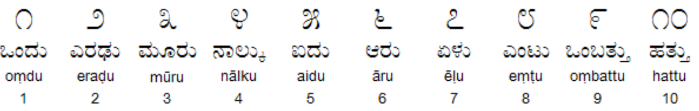


Note: This is a fork of @faizu07 kernel

### Checking the contents of data

In [ ]:
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))



**Note**:

Kannada-MNIST dataset contains the following files:

- train.csv
- test.csv
- sample_submission.csv

Rest of files in Input are `fastai-pretrained-models` from the [Kaggle Dataset](https://www.kaggle.com/pronkin/fastai-pretrained-models) fastiai-pretrained models with trained models:
- VGG16
- Resnets
- Densenet
- SqueezeNet 

### Loading the libraries

**FastAI:** Fast.ai is amazing Deep Learning library to make Deep neural networks uncool again. Their fast.ai Massive Open Online Course (MOOC) on [Practical Deep Learning for Coders is simply amazing.](https://course.fast.ai/)

**Numpy:** For Mathematical operations

**Pandas:** For handling CSV files

**matplotlib & seaborn:** Used for charting and plotting.

In [ ]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [ ]:
from fastai import *
from fastai.vision import *
import imageio
import numpy as np 
import pandas as pd 
import seaborn as sns

In [ ]:
path = Path('../input/Kannada-MNIST')
train = pd.read_csv('../input/Kannada-MNIST/train.csv')
test  =pd.read_csv('../input/Kannada-MNIST/test.csv')

### Analysing the given data


In [ ]:
train.head(5)

**Label:** This contains the label which are going to predict.That is our target value.Here it is numbers from 0 to 9 which represents the various Kannada characters.

**pixel0-783:** These are the pixel values of the image metrics.That is each row contains 28 * 28 = 784 (0-783 here) values here.Each one of these values indicates the pixel value at i x 28 + j th pixel position in the image metric.Simple !

In [ ]:
train.describe()

In [ ]:
y=train.label.value_counts()
sns.barplot(y.index,y)


We have an balanced dataset with equal no of images in each classes.There are 6000 examples of each numbers in kannada in the the training dataset.Cool !


**Preprocessing**

Using the function `to_img_shape`, you reshape the input data which is passed in the form:

`data_X:` Represents the various pixels of our data which is being passed and is reshaped adequately using numpy.

`data_y:` We make our label into a numpy array

In [ ]:
def to_img_shape(data_X, data_y=[]):
    data_X = np.array(data_X).reshape(-1,28,28)
    data_X = np.stack((data_X,)*3, axis=-1)
    data_y = np.array(data_y)
    return data_X,data_y

In [ ]:
data_X, data_y = train.loc[:,'pixel0':'pixel783'], train['label']


### Splitting train and test



Now we will split out training data into train and validation data.10% of the training data will be used for validation purpose.


In [ ]:
from sklearn.model_selection import train_test_split

train_X, val_X, train_y, val_y = train_test_split(data_X, data_y, test_size=0.10,random_state=7,stratify=data_y)

In [ ]:
train_X,train_y = to_img_shape(train_X, train_y)
val_X,val_y = to_img_shape(val_X,val_y)

In [ ]:
def save_imgs(path:Path, data, labels):
    path.mkdir(parents=True,exist_ok=True)
    for label in np.unique(labels):
        (path/str(label)).mkdir(parents=True,exist_ok=True)
    for i in range(len(data)):
        if(len(labels)!=0):
            imageio.imsave( str( path/str(labels[i])/(str(i)+'.jpg') ), data[i] )
        else:
            imageio.imsave( str( path/(str(i)+'.jpg') ), data[i] )

save_imgs(Path('/data/train'),train_X,train_y)
save_imgs(Path('/data/valid'),val_X,val_y)

### Applying Image augmentation

Currently we have about 6000 images of various characters in the classes. Yet in deep learning we usually face two problems ie Overfitting and Underfitting.

**Overfitting:** Our learned models gets too specific for the given problem, and is not able to generalise the solution for a data outside of the trained images. Have you ever
had that weird experience of getting very high accuracy and seeing it perform bad in real life example. This is why generally we prefer to have a bigger validation dataset.

**Underfitting:** Our model on having too less data is not able to learn the patterns from the given data

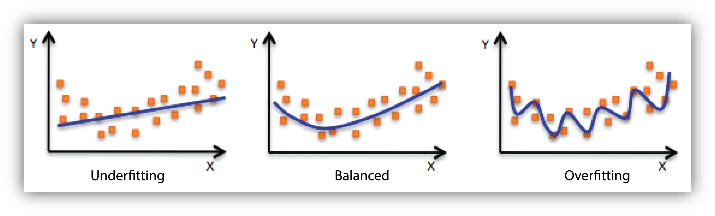

In order to avoid both these problems and to have a balanced model, we are using Image augmentation techniques to double or triple the available data.

Some popular augmentations people use are grayscales, horizontal flips, vertical flips, random crops, color jitters, translations, rotations, and much more.By applying just a couple of these transformations to our training data, we can easily double or triple the number of training examples and create a very robust model.

To learn more about Image augmentation techniques check out @init27s [amazing article](https://towardsdatascience.com/introduction-to-image-augmentations-using-the-fastai-library-692dfaa2da42).

In [ ]:
tfms = get_transforms(do_flip=False )

In [ ]:
data = (ImageList.from_folder('/data/') 
        .split_by_folder()          
        .label_from_folder()        
        .add_test_folder()          
        .transform(tfms, size=64)   
        .databunch())

In [ ]:
data

### Displaying a data bunch

Nicely displaying 9 images of given Kannada Alphabets

In [ ]:
data.show_batch(3,figsize=(6,6))

### Choosing the appropriate model

Using the correct model at the proper time is always, necessary. Use of internet is not allowed in this competiton, So we are using pre-trained models in the added kaggle dataset.

We are using **Resnet 101** for training our model. It fundamentally works on the principle of Resblocks which is a very revolutionary idea in the history of Deep Learning.


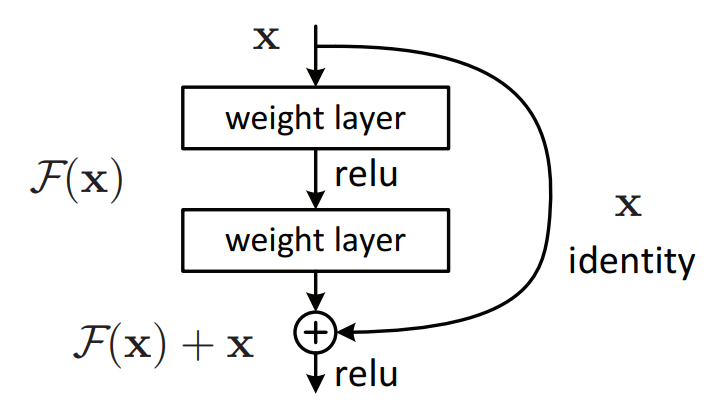

I am quoting what Jeremy Howards said during [Fastai Deep Learning Lesson7](https://www.youtube.com/watch?v=9spwoDYwW_I) about Resnets and how Resblocks originated:

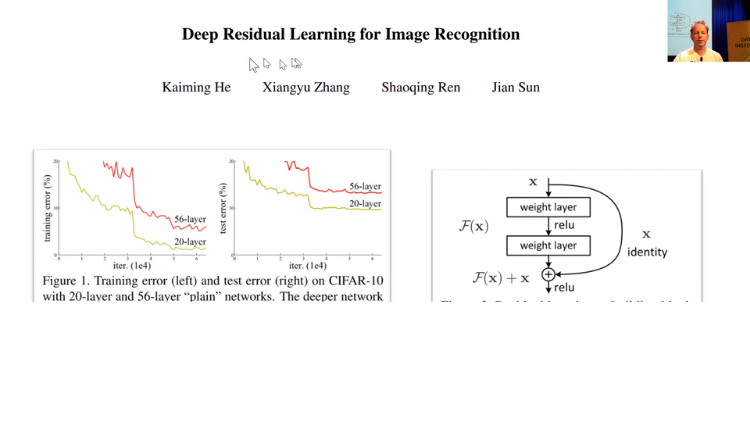
> The problem was pointed out in this paper, very influential paper called "Deep Residual Learning for Image Recognition" by Kaiming He and colleagues then at Microsoft Research. They did something interesting. Let's look at the training error. So forget generalization even. Let's look at the training error of a network train on CIFAR-10 and let's try one network with 20 layers just basic 3x3 conv basically the same network I've showed you but without BatchNorm. So I train a 20-layer one and the 56-layer one on the training set. So the 56-layer one has a lot more parameters, it got a lot more this stride 1 convs in the middle. The one with a lot more parameters should seriously overfit. You would expect the 56-layer one to zip down to zero-ish training error pretty quickly. And that is not what happened. It is worst for the shallower network.

> So when you see something wierd happen, really good researcher don't go "No it is not working.". They go "That's interesting.". Kaiming He said "That's interesting. What is going on?". He said "I don't know but what I do know is this. I could take this 56-layer network and make a new version of it which is identical but has to be at least as good as the 20-layer network and here's how. Every 2 convolutions, I am going to add together the input to those 2 convolutions, add it together with the result of those 2 convolutions.". In other words, he is saying instead of saying output = c2(c1(x)), instead he is saying output = x + c2(c1(x)). That 56-layer worth of convolutions in that.

> His theory was has to be at least as good as the 20-layer version because it could always just set conv2 and conv1 to a bunch of weights for everything except for the first 20 layers because the x, the input can just go straight through. So this thing here as you can see called an identity connection. It's the "identity" function, nothing happen at all. It is also known as the skip connection.
So that was the theory. That is what the paper described as the intuition behind this is what would happen if we created something which has to train at least as well as the 20-layer neural network because it kind of contains the 20-layer neural network is literally a path you can skip over all the convolutions

In [ ]:
# Copying pretrained models from fastai-pretrained models in data to adequate folder
!mkdir -p /tmp/.cache/torch/checkpoints
!cp /kaggle/input/fastai-pretrained-models/resnet101-5d3b4d8f.pth /tmp/.cache/torch/checkpoints/resnet101-5d3b4d8f.pth


In [ ]:
learn = cnn_learner(data, models.resnet101, metrics=[error_rate, accuracy], model_dir = Path('../kaggle/working'),path = Path("."))

In [ ]:
learn.fit_one_cycle(3)

In [ ]:
learn.lr_find()

In [ ]:
learn.recorder.plot()

In [ ]:
lr = slice(2e-05)

In [ ]:
learn.save('stage-1')

### Training our model for 2 more epochs

In [ ]:
learn.unfreeze()

In [ ]:
learn.fit_one_cycle(2,lr)

In [ ]:
learn.save('stage-2')

### Making Submission

In [ ]:
test_csv = pd.read_csv('../input/Kannada-MNIST/test.csv')
test_csv.drop('id',axis = 'columns',inplace = True)
sub_df = pd.DataFrame(columns=['id','label'])

In [ ]:
test_data = np.array(test_csv)

In [ ]:
# Handy function to get the image from the tensor data
def get_img(data):
    t1 = data.reshape(28,28)/255
    t1 = np.stack([t1]*3,axis=0)
    img = Image(FloatTensor(t1))
    return img

We will make the final prediction for Test dataset using our trained ML model `learn`. 

Note: fastprogress is used to calculate the interference time as progess bar for the dataset

In [ ]:
from fastprogress import progress_bar
mb=progress_bar(range(test_data.shape[0]))

In [ ]:
for i in mb:
    timg=test_data[i]
    img = get_img(timg)
    sub_df.loc[i]=[i+1,int(learn.predict(img)[1])]

In [ ]:
def decr(ido):
    return ido-1

sub_df['id'] = sub_df['id'].map(decr)
sub_df.to_csv('submission.csv',index=False)

In [ ]:
# Displaying the submission file
sub_df.head()

In [ ]:
# interfering the learner class with one image

img = data.train_ds[0][0]
learn.predict(img)

<a href="./submission.csv"> Download Submission File </a>


### Thank You


<div align='left'><font size='5' color=' #a93226 '>  If you like my work,please do upvote ^ </font></div>

## References

- https://www.kaggle.com/shahules/indian-way-to-learn-cnn
- https://docs.fast.ai/